# Real data application

In [2]:
data_dir = pathlib.Path("..") / "data"

In [3]:
data = pd.read_csv(data_dir / "rio-de-janeiro-magnetic.csv")
data

,longitude,latitude,total_field_anomaly_nT,altitude_m,line_number,easting_m,northing_m,deriv_up,deriv_east,deriv_north
0,-42.639984,-22.290527,-16.56,151.49,2800,-4.393928e+06,-2.342215e+06,0.159488,0.045283,-0.096695
1,-42.639969,-22.291397,-43.47,162.46,2800,-4.393926e+06,-2.342311e+06,0.118291,0.053503,-0.125651
2,-42.639954,-22.292267,-65.38,170.69,2800,-4.393925e+06,-2.342407e+06,0.065451,0.062132,-0.143214
3,-42.639938,-22.293152,-74.29,173.43,2800,-4.393923e+06,-2.342505e+06,0.003259,0.071041,-0.146666
4,-42.639923,-22.294022,-67.20,170.08,2800,-4.393922e+06,-2.342602e+06,-0.063629,0.079413,-0.132554
...,...,...,...,...,...,...,...,...,...,...
50877,-41.905685,-22.497009,163.33,143.87,4600,-4.318260e+06,-2.365096e+06,-0.022036,-0.000077,-0.043498
50878,-41.905685,-22.497879,175.29,142.34,4600,-4.318260e+06,-2.365192e+06,-0.033156,0.002121,-0.036070
50879,-41.905701,-22.498734,180.25,140.51,4600,-4.318262e+06,-2.365287e+06,-0.041334,0.004720,-0.027289
50880,-41.905701,-22.499588,175.21,138.68,4600,-4.318262e+06,-2.365382e+06,-0.046377,0.007345,-0.018021


In [77]:
%%time
window_size = 12e3
window_step = window_size / 5
ei = euler.EulerInversionWindowed(
    window_size=window_size,
    window_step=window_step,
    keep=0.1,
).fit(
    coordinates=(data.easting_m.values, data.northing_m.values, data.altitude_m.values), 
    data=(data.total_field_anomaly_nT.values, data.deriv_east.values, data.deriv_north.values, data.deriv_up.values),
)

CPU times: user 717 ms, sys: 326 ms, total: 1.04 s
Wall time: 7.65 s


/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x7bae68102840> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/verde/blockreduce.py:236: FutureWarning: The provided callable <function median at 0x7bae68102840> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reduction)


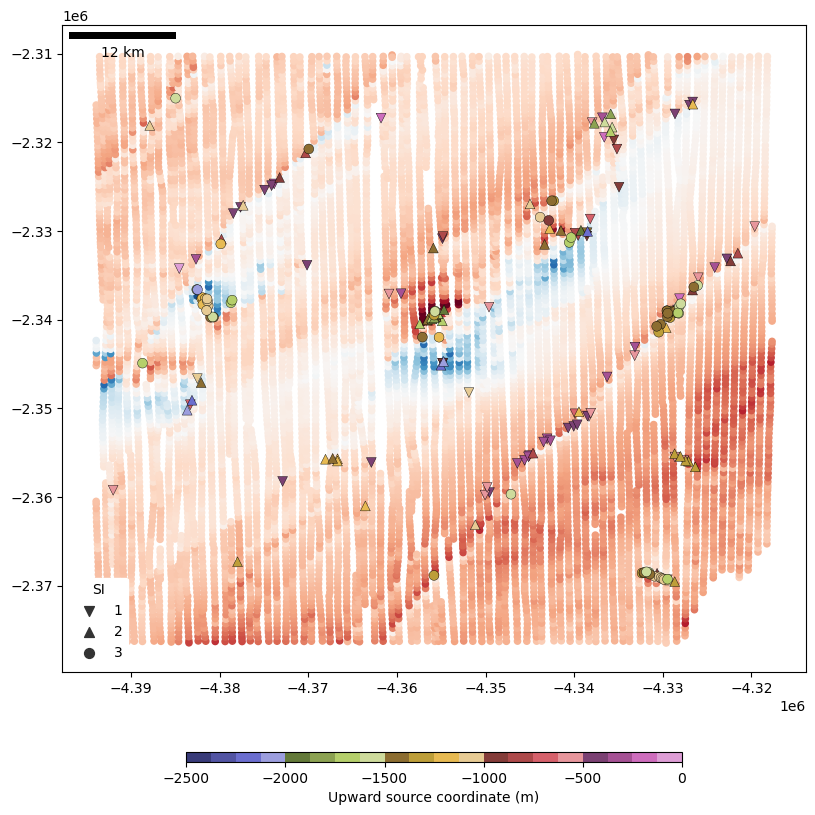

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), layout="constrained")
scale = np.percentile(np.abs(data.total_field_anomaly_nT), 99.9)
block_coords, block_mag = vd.BlockReduce(np.median, spacing=500).filter((data.easting_m, data.northing_m), data.total_field_anomaly_nT)
ax.scatter(*block_coords, s=20, c=block_mag, vmin=-scale, vmax=scale, cmap="RdBu_r")
ax.set_aspect("equal")
markers = ["v", "^", "o"]
labels = {}
size = 50
vmin, vmax = -2500, 0
for si, marker in zip([1, 2, 3], markers):
    is_si = ei.structural_indices_ == si
    tmp = ax.scatter(
        *ei.locations_[:2, is_si],
        c=ei.locations_[2, is_si],
        s=size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=0.3,
        cmap="tab20b",
    )
    labels[si] = ax.scatter([], [], c="#333333", s=size, marker=marker)
ax.legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    loc="lower left",
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    title="SI",
)
fig.colorbar(
    tmp,
    ax=ax,
    aspect=50,
    pad=0.05,
    shrink=0.5,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)
ax.add_artist(
        ScaleBar(
            dx=0.001, 
            fixed_value=window_size / 1000,
            units="km", 
            location="upper left", 
            box_alpha=0,
            color="black", 
            scale_loc="bottom", 
            width_fraction=0.01, 
            length_fraction=0.1,
            pad=0.4,
            scale_formatter=lambda value, unit: f"{value:.0f} {unit}",
        )
    )

## Slices

In [50]:
area = [-4.365e6, -4.345e6, -2.35e6, -2.33e6]
data_area = data[vd.inside((data.easting_m, data.northing_m), area)]

In [51]:
ei = euler.EulerInversion(structural_index=3).fit(
    coordinates=(data_area.easting_m.values, data_area.northing_m.values, data_area.altitude_m.values), 
    data=(data_area.total_field_anomaly_nT.values, data_area.deriv_east.values, data_area.deriv_north.values, data_area.deriv_up.values),
)

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x7bae68102840> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/verde/blockreduce.py:236: FutureWarning: The provided callable <function median at 0x7bae68102840> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reduction)


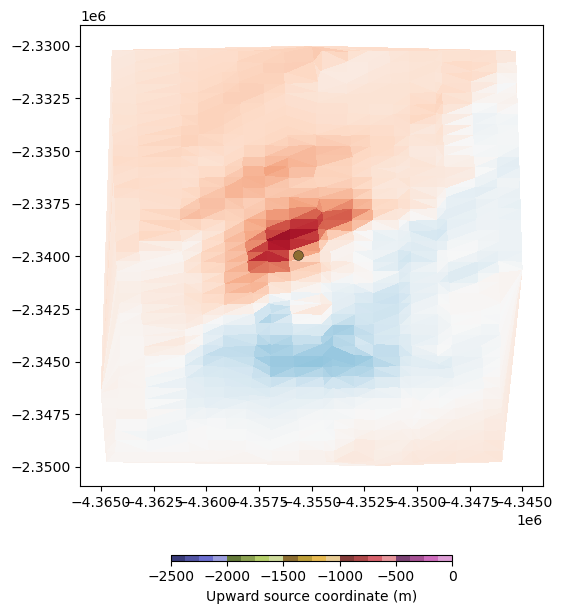

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), layout="constrained")
scale = np.percentile(np.abs(data_area.total_field_anomaly_nT), 99.9)
block_coords, block_mag = vd.BlockReduce(np.median, spacing=500).filter((data_area.easting_m, data_area.northing_m), data_area.total_field_anomaly_nT)
ax.tripcolor(*block_coords, block_mag, vmin=-scale, vmax=scale, cmap="RdBu_r")
ax.set_aspect("equal")
tmp = ax.scatter(
    *ei.location_[:2],
    c=ei.location_[2],
    s=size,
    marker="o",
    vmin=vmin,
    vmax=vmax,
    edgecolors="black",
    linewidths=0.3,
    cmap="tab20b",
)
fig.colorbar(
    tmp,
    ax=ax,
    aspect=50,
    pad=0.05,
    shrink=0.5,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)

In [86]:
area = [-4.35e6, -4.33e6, -2.36e6, -2.340e6]
data_area = data[vd.inside((data.easting_m, data.northing_m), area)]

In [87]:
ei = euler.EulerInversion(structural_index=1).fit(
    coordinates=(data_area.easting_m.values, data_area.northing_m.values, data_area.altitude_m.values), 
    data=(data_area.total_field_anomaly_nT.values, data_area.deriv_east.values, data_area.deriv_north.values, data_area.deriv_up.values),
)

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x7bae68102840> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/verde/blockreduce.py:236: FutureWarning: The provided callable <function median at 0x7bae68102840> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reduction)


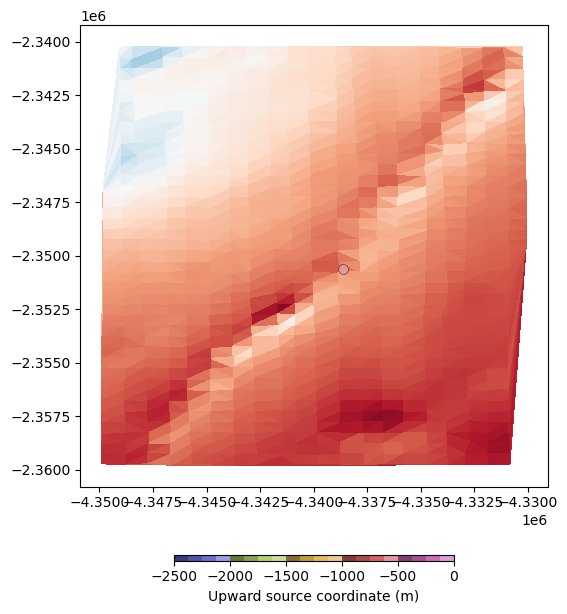

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), layout="constrained")
scale = np.percentile(np.abs(data_area.total_field_anomaly_nT), 99.9)
block_coords, block_mag = vd.BlockReduce(np.median, spacing=500).filter((data_area.easting_m, data_area.northing_m), data_area.total_field_anomaly_nT)
ax.tripcolor(*block_coords, block_mag, vmin=-scale, vmax=scale, cmap="RdBu_r")
ax.set_aspect("equal")
tmp = ax.scatter(
    *ei.location_[:2],
    c=ei.location_[2],
    s=size,
    marker="o",
    vmin=vmin,
    vmax=vmax,
    edgecolors="black",
    linewidths=0.3,
    cmap="tab20b",
)
fig.colorbar(
    tmp,
    ax=ax,
    aspect=50,
    pad=0.05,
    shrink=0.5,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)

In [65]:
area = [-4.39e6, -4.375e6, -2.345e6, -2.33e6]
data_area = data[vd.inside((data.easting_m, data.northing_m), area)]

In [66]:
ei = euler.EulerInversion(structural_index=3).fit(
    coordinates=(data_area.easting_m.values, data_area.northing_m.values, data_area.altitude_m.values), 
    data=(data_area.total_field_anomaly_nT.values, data_area.deriv_east.values, data_area.deriv_north.values, data_area.deriv_up.values),
)

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x7bae68102840> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/verde/blockreduce.py:236: FutureWarning: The provided callable <function median at 0x7bae68102840> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reduction)


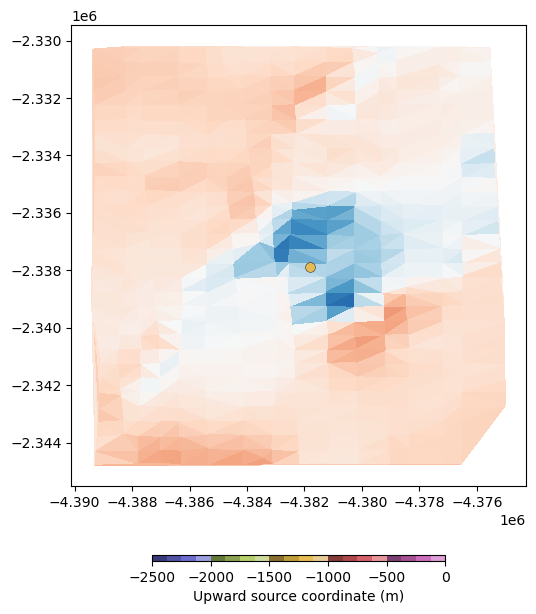

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), layout="constrained")
scale = np.percentile(np.abs(data_area.total_field_anomaly_nT), 99.9)
block_coords, block_mag = vd.BlockReduce(np.median, spacing=500).filter((data_area.easting_m, data_area.northing_m), data_area.total_field_anomaly_nT)
ax.tripcolor(*block_coords, block_mag, vmin=-scale, vmax=scale, cmap="RdBu_r")
ax.set_aspect("equal")
tmp = ax.scatter(
    *ei.location_[:2],
    c=ei.location_[2],
    s=size,
    marker="o",
    vmin=vmin,
    vmax=vmax,
    edgecolors="black",
    linewidths=0.3,
    cmap="tab20b",
)
fig.colorbar(
    tmp,
    ax=ax,
    aspect=50,
    pad=0.05,
    shrink=0.5,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)

In [102]:
area = [-4.35e6, -4.335e6, -2.34e6, -2.325e6]
data_area = data[vd.inside((data.easting_m, data.northing_m), area)]

In [103]:
ei = euler.EulerInversion(structural_index=3).fit(
    coordinates=(data_area.easting_m.values, data_area.northing_m.values, data_area.altitude_m.values), 
    data=(data_area.total_field_anomaly_nT.values, data_area.deriv_east.values, data_area.deriv_north.values, data_area.deriv_up.values),
)

/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/verde/blockreduce.py:179: FutureWarning: The provided callable <function median at 0x7bae68102840> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/verde/blockreduce.py:236: FutureWarning: The provided callable <function median at 0x7bae68102840> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reduction)


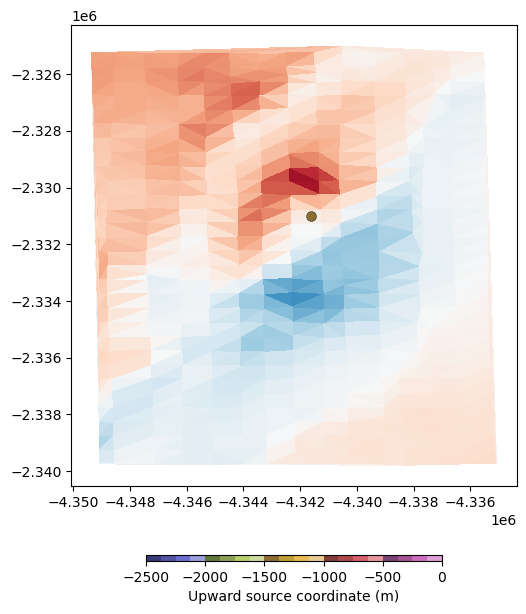

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), layout="constrained")
scale = np.percentile(np.abs(data_area.total_field_anomaly_nT), 99.9)
block_coords, block_mag = vd.BlockReduce(np.median, spacing=500).filter((data_area.easting_m, data_area.northing_m), data_area.total_field_anomaly_nT)
ax.tripcolor(*block_coords, block_mag, vmin=-scale, vmax=scale, cmap="RdBu_r")
ax.set_aspect("equal")
tmp = ax.scatter(
    *ei.location_[:2],
    c=ei.location_[2],
    s=size,
    marker="o",
    vmin=vmin,
    vmax=vmax,
    edgecolors="black",
    linewidths=0.3,
    cmap="tab20b",
)
fig.colorbar(
    tmp,
    ax=ax,
    aspect=50,
    pad=0.05,
    shrink=0.5,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)